<a href="https://colab.research.google.com/github/MichalSien/Michal-Lab/blob/main/LAB1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math  as m
import numpy as np

# liczby losowe
import random

# grafika do wykresów
import matplotlib.pyplot as plt
import matplotlib as mpl

# działania na łańcuchach znaków
import string 

# statystyka
import statistics as st

# pomar czasu
import time

# dopasowywanie krzywych do danych
from scipy.optimize import curve_fit

# wyświetlanie importowanej grafiki
from IPython.display import display, Image

# wykresy konturowe
import matplotlib.cm as cm

In [2]:
def plot_net(n_war):
    """Narysuj szkielet sieci"""
    li_war=len(n_war)
    plt.figure(figsize=(7,4)) # rozmiar rysunku

    for i in range(li_war): # pętla po warstwach
        for j in range(1,n_war[i]): # pętla po węzłach innych niż progowe w warstwie (zaczynamy od 1)
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue') 
            # rysuj punkt o współrzędnej poziomej i oraz współrzędnej pionowej rosnącej z j 
            # odjęcie n_war[i]/2 powoduje, że średnie pionowe połozenie punktów jest 0
        
    for i in range(li_war-1): # pętla po warstwach z wyjatkiem outputowej
            plt.scatter(i, 0-n_war[i]/2, s=100,c='gray') # dodaj węzły progowe innym kolorem
    
    for i in range(li_war-1): # pętla po warstwach z wyjątkim ostatniej
        for j in range(n_war[i]): # pętla po węzłach, z których wychodzi krawędź
            for k in range(n_war[i+1]-1):  # pętla po węzłach z kolejnej wartwy, do których wchodzi krawędź
                plt.plot([i,i+1],[j-n_war[i]/2,k+1-n_war[i+1]/2],c='gray') # rysowanie krawędzi
                # współrzędne odpowiadają współrzędnym punktu

    plt.title("Sieć o inpucie i " + str(li_war-1)+" warstwach",fontsize=16)
    plt.axis("off")
    plt.show()

In [3]:
def plot_net_w(n_war, wagi):
    """Narysuj sieć z wagami"""
    li_war=len(n_war)
    plt.figure(figsize=(7,4)) # rozmiar rysunku

    for i in range(li_war): # pętla po warstwach
        for j in range(1,n_war[i]): # pętla po węzłach innych niż progowe w warstwie (zaczynamy od 1)
            plt.scatter(i, j-n_war[i]/2, s=100,c='blue') 
            # rysuj punkt o współrzędnej poziomej i oraz współrzędnej pionowej rosnącej z j 
            # odjęcie n_war[i]/2 powoduje, że średnie pionowe połozenie punktów jest 0
        
    for i in range(li_war-1): # pętla po warstwach z wyjatkiem outputowej
            plt.scatter(i, 0-n_war[i]/2, s=100,c='gray') # dodaj węzły progowe innym kolorem
    
    li_par=0 #liczba wag
    
    for i in range(li_war-1):
        for j in range(n_war[i]):
            for k in range(n_war[i+1]-1):
                li_par+=1
                th=3*wagi[i+1][j][k]
                if th>0:
                    col='red'
                else:
                    col='blue'
                th=abs(th)
                plt.plot([i,i+1],[j-n_war[i]/2,k+1-n_war[i+1]/2],c=col,linewidth=th)
                

    plt.title("Sieć o inpucie i "+str(li_war-1)+" warstwach (liczba wag: "+str(li_par)+")",fontsize=16)
    plt.axis("off")
    plt.show()

In [4]:
# skrót dla generowania liczby losowej w przedziale (-0.5,0.5)
def rn():
    return random.random()-0.5
# losowe wagi z przedziału (-0.5,0.5)
def ran_w(n_war):
    li_war=len(n_war) 
    wa={}
    for k in range(len(n_war)-1):
        wa.update({k+1: [[rn() for i in range(n_war[k+1]-1)] for j in range(n_war[k])]})
    return wa
# losowe wagi z przedziału (-0.5s,0.5s)
def ran_w_s(n_war,s):
    li_war=len(n_war) 
    wa={}
    for k in range(len(n_war)-1):
        wa.update({k+1: [[s*rn() for i in range(n_war[k+1]-1)] for j in range(n_war[k])]})
    return wa

In [5]:
def back_prop(dane, odp, p, n_war, wagi, eps):
    """Propagacja wsteczna"""

    li_war=len(n_war) # liczba warstw (licząc wszystkie)

    po=np.insert(dane[p],0,1) # dodanie do punktu danych jedynki na początku (węzeł progowy)

    x=feed_forward_sig(n_war,wagi,po) # propagacja sygnału do przodu z sigmoidem
   
    n=n_war[li_war-1]-1  # liczba neuronów w warstwie outputowej 
    
    k=len(n_war)-2       # liczba warstw pośrednich
                         # wszystkich warstw jest k+2, są numerowane jako 0,1,2,...,k+1
                         # tj. 0 - inputowa, k+1 - outputowa, pozostałe pośrednie

    D={}                 # słownik dla wielkości D z wyprowadzenia
    
    D.update({k+1:       # D[k+1] - dla warstwy outputowej
        [2*(x[k+1][gam]-odp[p][gam-1])*dsig(np.dot(x[k],wagi[k+1]))[gam-1] for gam in range(1,n+1)]})   

    wagi[k+1]-=eps*np.outer(x[k],D[k+1]) # uaktualnienie wag prowadzących do warstwy outputowej
    
    # pętla po pozostałych warstwach po j = k, k-1, ..., 1
    for j in reversed(range(1,k+1)):            # pętla w odwrotnej kolejności
        u=np.delete(np.dot(wagi[j+1],D[j+1]),0) # implementacja wzoru z wyprowadzena
        v=dsig(np.dot(x[j-1],wagi[j]))          # ...
        D.update({j: [u[i]*v[i] for i in range(len(u))]}) # dopisanie D[j] do słownika
        wagi[j]-=eps*np.outer(x[j-1],D[j])      # uaktualnienie wag

In [6]:
# sigmoid, inaczej funkcja logistyczna, a także (1+arctanh(-s/2))/2 
def sig(s):
    return 1/(1+np.exp(-s))
s = np.linspace(-10, 10, 100)

fs = [sig(z) for z in s]
# pochodna sigmoidu
def dsig(s):
     return sig(s)*(1-sig(s)) # szczególna cecha tej funkcji

dfs = [dsig(z) for z in s]  
def feed_forward_sig(n_war, wagi, x_in):
    """Propagacja sygnału w przód"""
    li_war=len(n_war)
    
    x={} # słownik, który będzie zawierać warości sygnałów we wszystkich warstwach
    x.update({0: np.array(x_in)}) 
    
    for i in range(1,li_war): # pętla po warstwach począwszy od pierwszej po inpucie
        a=np.dot(x[i-1],wagi[i]) # sygnał docierający do warstwy i
        b=[sig(a[q]) for q in range(len(a))] # sygnał wychodzacy z warstwy (określony przez funkcję aktywacji)
        x.update({i: np.insert(b,0,1)}) # dopisanie do słownika po wstawieniu sygnału 1 dla węzła progowego
        
    return x

In [7]:
# zwraca losowe współrzędne x1, x2 oraz 1 dla punktów 
# w kole o środku (0.5,0.5) i promeniu 0.4, a 0 poza nim

def kolo():
    x1=random.random()
    x2=random.random()
    if((x1-0.5)*(x1-0.5)+(x2-0.5)*(x2-0.5) < 0.4*0.4): # w kole
        return np.array([x1,x2,1])
    else:                                              # poza kołem
        return np.array([x1,x2,0])

In [8]:
# losowa próbka szkoleniowa 3000 punktów 
probka_k=np.array([kolo() for i in range(3000)])
da_k=np.delete(probka_k,2,1)
od_k=np.delete(np.delete(probka_k,0,1),0,1)

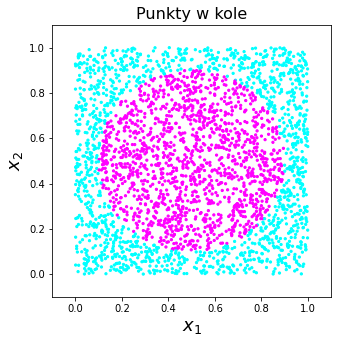

In [9]:
plt.figure(figsize=(5,5))
plt.title("Punkty w kole",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(probka_k[:,0],probka_k[:,1],c=probka_k[:,2],
            s=5,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

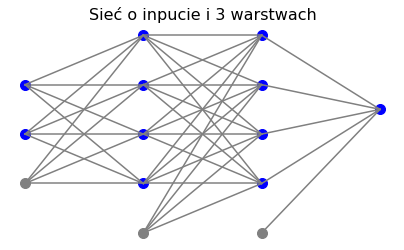

In [10]:
# sieć o dość pokaźnej liczbie neuronów
siec=[3,5,5,2]
plot_net(siec)

wagi=ran_w_s(siec,5.); # początkowe losowe wagi

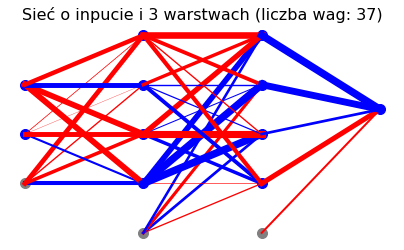

In [11]:

plot_net_w(siec,wagi)

In [12]:
# uczenie trwa dość długo, trzeba tę komórkę przepuścić wiele razy

eps=.7

for k in range(100):  # 500 rund
    eps=.99*eps
    if k%10==9:
        print(k+1,' ',end='')
    for p in range(len(probka_k)):
        back_prop(da_k,od_k,p,siec,wagi,eps)

10  20  30  40  50  60  70  80  90  100  

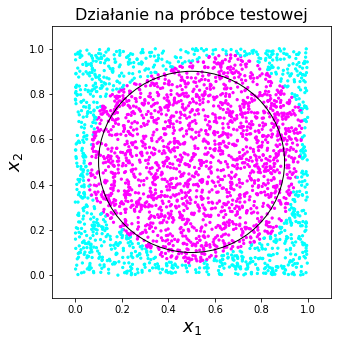

In [13]:
test=[] # próbka testowa

for k in range(3000):
    po=[1,random.random(),random.random()]  # nowy punkt testowy
    xt=feed_forward_sig(siec,wagi,po)    # generowanie wyniku dla tego punktu
    test.append([po[1],po[2],np.round(xt[3][1],0)]) # zapis do tablicy

tt=np.array(test) # zmiana formatu tablicy na numpy  

fig=plt.figure(figsize=(5,5))

# dorysowanie okręgu
ax=fig.add_subplot(1,1,1)
circ=plt.Circle((0.5,0.5), radius=.4, color='black', fill=False)
ax.add_patch(circ)

plt.title("Działanie na próbce testowej",fontsize=16) 
plt.xlim(-.1,1.1)
plt.ylim(-.1,1.1)
plt.scatter(tt[:,0],tt[:,1],c=tt[:,2],
            s=5,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=0, vmax=.9))

plt.xlabel('$x_1$',fontsize=18)
plt.ylabel('$x_2$',fontsize=18);

In [14]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib as mpl

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

In [15]:
def kwadrat():
    x1=random.random()
    x2=random.random()
    if(0.05 < (x1-0.75)*(x1-0.25))+(x2-0.75)*(x2-0.25) < 0.05:
        return np.array([x1,x2,1])
    else:
        return np.array([x1,x2,0])

In [16]:

probka_k=np.array([kwadrat() for i in range(6000)])
print(probka_k.shape)

(6000, 3)


In [17]:
def draw_result(X,y): 
  fig=plt.figure(figsize=(5,5))

  # dorysowanie okręgu
  #ax=fig.add_subplot(1,1,1)
  #circ=plt.Circle((0.5,0.5), radius=.4, color='black', fill=False)
  #ax.add_patch(circ)

  plt.title("Działanie na próbce testowej",fontsize=16) 
  plt.xlim(min(X[:,0]),max(X[:,0]))
  plt.ylim(min(X[:,1]),max(X[:,1]))
  plt.scatter(X[:,0],X[:,1],c=y,
            s=5,cmap=mpl.cm.cool,norm=mpl.colors.Normalize(vmin=min(y), vmax=max(y)))

  plt.xlabel('$x_1$',fontsize=18)
  plt.ylabel('$x_2$',fontsize=18);

Shapes of datasets X_train, X_test, y_train, y_test:  (3000, 2) (3000, 2) (3000,) (3000,)


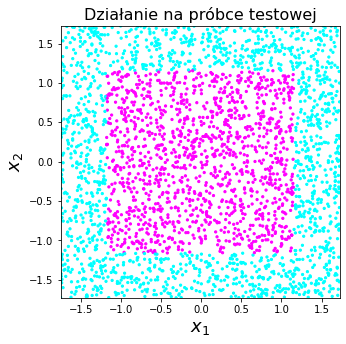

In [18]:
X, y = probka_k[:,:2], probka_k[:,2]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42)

print("Shapes of datasets X_train, X_test, y_train, y_test: ",X_train.shape, X_test.shape, y_train.shape, y_test.shape)

#narysuj dane testowe
draw_result(X_test, y_test)

In [19]:
clf = MLPClassifier(hidden_layer_sizes=(5,5), activation='tanh', alpha=0.1, 
                    learning_rate_init=0.01, early_stopping=True,validation_fraction=0.2,verbose=True,n_iter_no_change=100,max_iter=1000)
                    #max_iter=1000) 


print(clf.fit(X_train, y_train))

# get score
score = clf.score(X_test, y_test)
print("Score = ",score)

# get prediction
Z = clf.predict_proba(X_test)[:,1] # returns probability 
print(Z)

Iteration 1, loss = 0.80759510
Validation score: 0.563333
Iteration 2, loss = 0.68127834
Validation score: 0.553333
Iteration 3, loss = 0.67120816
Validation score: 0.528333
Iteration 4, loss = 0.65460439
Validation score: 0.730000
Iteration 5, loss = 0.64171198
Validation score: 0.705000
Iteration 6, loss = 0.62615060
Validation score: 0.691667
Iteration 7, loss = 0.60638809
Validation score: 0.730000
Iteration 8, loss = 0.58380495
Validation score: 0.726667
Iteration 9, loss = 0.56262450
Validation score: 0.725000
Iteration 10, loss = 0.54365193
Validation score: 0.725000
Iteration 11, loss = 0.51776467
Validation score: 0.753333
Iteration 12, loss = 0.48177366
Validation score: 0.785000
Iteration 13, loss = 0.42520316
Validation score: 0.870000
Iteration 14, loss = 0.36123190
Validation score: 0.910000
Iteration 15, loss = 0.31209113
Validation score: 0.923333
Iteration 16, loss = 0.28022370
Validation score: 0.916667
Iteration 17, loss = 0.25983658
Validation score: 0.926667
Iterat